# W261 Final Project

### Team Members:
- Walt Burge
- Avinash Chandrasekaran
- James De La Torre
- Jae Il Lee
- Sylvia Yang

### 1. Introduction

In this final project, we will perform Click Through Rate prediction on a large dataset of Criteo advertising data that is made public as part of a Kaggle competition. 

Click through rate (CTR) is a ratio showing how often people who see an ad end up clicking it. This ratio can be used to gauge how well the keywords and the ads are performing. CTR is the number of clicks that a ad receives divided by the number of times a ad is shown: clicks ÷ impressions = CTR. For example, if we had 5 clicks and 100 impressions, then our CTR would be 5%. A high CTR is a good indication that users find the ads helpful and relevant. The CTR metric can be used to gauge which ads/keywords are successful vs. which ones need to be improved. The more the keywords and ads relate to each other and to a particular business, the more likely a user is to click on the ad after searching on a keyword phrase.

In this project, we will perform a CTR prediction on a public dataset of Criteo advertising data. As part of this, we will first perform an exploratory data analysis (EDA), and from this EDA determine if binary logistic regression is an appropriate algorithm to use for CTR prediction. In this pursuit, we will thoroughly test out all assumptions of using a logistic regression model. If determined appropriate, we will apply binary logictic regression to a handcrafted toy example to test out general algorithm implemented before applying to the full train and test data provided. Our target label (variable) will take a binary value (0 or 1) corresponding to whether or not a display ad served was clicked. 

The leaderboard of the public Kaggle competition indicates a log-loss score of 0.445 with a good majority achieving scores of ~0.46. Through optimizations we will aim to achieve a similar score. 

### 2. Exploratory Data Analysis

We will first explore the dataset provided in an attempt to better understand it before we start the CTR prediction modeling. From the data description provided in the Kaggle website, each row of the dataset contains three different types of variables, namely:

* Label - Target variable that indicates if an ad was clicked (1) or not (0).

* I1-I13 - A total of 13 columns of integer features (mostly count features).

* C1-C26 - A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes. 

The semantics of the features have not been disclosed but we've explored the domain space and the available features in display advertising and response prediction to further understand the characterisitcs of the dataset and align with our EDA and solution. The type of data that becomes available in most advertisiting systems can be categorized as 4 types : *advertiser*, *publisher*, *user*, *time* and a represnetative list of features for each group can be found below : 

|Feature Family|Feature Members|
|:----------:|:-------------:|
|Advertiser|advertiser id, campaign id, creative, ad category|
|Publisher|publisher id, site, section, url, page count|
|User|gender, age, region, network speed, geo, interaction count|
|Time|serve time, click time|

Most of the features are categorical features with large cardinality and sparsity and due to this nature, representation of the data in our model and reducing the dimensionality was the focus around building a scalable model that can appropriately scale with respect to the number of features.

In this Exploratory Data Analysis, we will start with examining the format and structure of the dataset, the size of the dataset, examine it for missing entries and outliers. We will then list out the summary statistics that will provide a better view of the distribution of the dataset. To further aid in our analysis, we will plot several graphs that augment our understanding of the distribution of the dataset.

For our project, we aim to use logistic regression algorithm for CTR prediction. Logictic regression models have several assumptions that must be met before they can used. These assumptions include:

* The outcome variable is a binary value i.e. 1 or 0, 'yes' or 'no' etc

* There is a linear relationship between the logit of the outcome and each predictor variable. The logit function is $logit(p) = log(p/(1-p))$, where 'p' is the probability of the outcome

* All of the observations should be independent

* There is no multicollinearity among the independent variables

* There are large number of observations

Given the public dataset, we already know that the target outcome variable is binary i.e. whether the ad is clicked or not. In addition, it should be safe to assume observations are independent. Each row in the dataset corresponds to a separately presented display ad. It is thus reasonable to make this assumption. These two satisfy two of the 5 assumptions stated above.

Also as seen above, there are 26 columns of categorical features. This appears to be one of the limitations as logictic regression model accepts only numerical values. To address this issue, we will convert the categorical columns into indicator variable using a process called one-hot encoding (OHE). Without this step, we will be unable to use the columns as is thus reducing the predictive power of our model.

As we conduct our EDA, we will evaluate the remaining assumptions on logistic regression model.

In [1]:
import ast
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import time
import statsmodels.formula.api as smf
import pylab as pl
from pyspark.mllib.stat import Statistics # Use for computing mean and variance when standardizing

In [2]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_proj_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [3]:
from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark.sql import functions as F, types
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StandardScaler, PCA
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.linalg import SparseVector
from pyspark.sql.functions import (explode, col)
from pyspark.sql.functions import col, row_number, concat, lit
from pyspark.sql.functions import trim
from pyspark.sql.functions import udf
from pyspark.sql.functions import split
from pyspark.sql.functions import when, log, col
from pyspark.sql.types import ArrayType, StructType, StructField, LongType, StringType
from pyspark.sql.types import FloatType
from pyspark.sql.types import Row
from pyspark.sql.window import Window
from pyspark.ml.stat import Correlation
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [4]:
# Read into data frame and adjust column names
rawDF = sqlContext.read.text('data/train.txt').withColumnRenamed("value", "text")
rawDF.cache()
fullWithColsDF = rawDF.withColumn('tmp', split('text', '\t')). \
                    select(col("tmp").getItem(0).cast("double").alias("label"),
                           col("tmp").getItem(1).cast("double").alias("int_1"), 
                           col("tmp").getItem(2).cast("double").alias("int_2"),
                           col("tmp").getItem(3).cast("double").alias("int_3"),
                           col("tmp").getItem(4).cast("double").alias("int_4"),
                           col("tmp").getItem(5).cast("double").alias("int_5"),
                           col("tmp").getItem(6).cast("double").alias("int_6"),
                           col("tmp").getItem(7).cast("double").alias("int_7"),
                           col("tmp").getItem(8).cast("double").alias("int_8"),
                           col("tmp").getItem(9).cast("double").alias("int_9"),
                           col("tmp").getItem(10).cast("double").alias("int_10"),
                           col("tmp").getItem(11).cast("double").alias("int_11"),
                           col("tmp").getItem(12).cast("double").alias("int_12"),
                           col("tmp").getItem(13).cast("double").alias("int_13"),
                           col("tmp").getItem(14).alias("categ_1"),
                           col("tmp").getItem(15).alias("categ_2"),
                           col("tmp").getItem(16).alias("categ_3"),
                           col("tmp").getItem(17).alias("categ_4"),
                           col("tmp").getItem(18).alias("categ_5"),
                           col("tmp").getItem(19).alias("categ_6"),
                           col("tmp").getItem(20).alias("categ_7"),
                           col("tmp").getItem(21).alias("categ_8"),
                           col("tmp").getItem(22).alias("categ_9"),
                           col("tmp").getItem(23).alias("categ_10"),
                           col("tmp").getItem(24).alias("categ_11"),
                           col("tmp").getItem(25).alias("categ_12"),
                           col("tmp").getItem(26).alias("categ_13"),
                           col("tmp").getItem(27).alias("categ_14"),
                           col("tmp").getItem(28).alias("categ_15"),
                           col("tmp").getItem(29).alias("categ_16"),
                           col("tmp").getItem(30).alias("categ_17"),
                           col("tmp").getItem(31).alias("categ_18"),
                           col("tmp").getItem(32).alias("categ_19"),
                           col("tmp").getItem(33).alias("categ_20"),
                           col("tmp").getItem(34).alias("categ_21"),
                           col("tmp").getItem(35).alias("categ_22"),
                           col("tmp").getItem(36).alias("categ_23"),
                           col("tmp").getItem(37).alias("categ_24"),
                           col("tmp").getItem(38).alias("categ_25"),
                           col("tmp").getItem(39).alias("categ_26")
                        ).cache()

# Print first row and check schema
fullWithColsDF.first()

Row(label=0.0, int_1=0.0, int_2=628.0, int_3=4.0, int_4=1.0, int_5=1732.0, int_6=291.0, int_7=57.0, int_8=19.0, int_9=19.0, int_10=0.0, int_11=7.0, int_12=None, int_13=1.0, categ_1='68fd1e64', categ_2='287130e0', categ_3='61f559fa', categ_4='3c6543d9', categ_5='25c83c98', categ_6='', categ_7='397def4e', categ_8='0b153874', categ_9='a73ee510', categ_10='0af798a0', categ_11='20b05825', categ_12='9efd7e1b', categ_13='c28589ee', categ_14='b28479f6', categ_15='9efd8b77', categ_16='c4089ccc', categ_17='e5ba7672', categ_18='891589e7', categ_19='315ba0e1', categ_20='b1252a9d', categ_21='63b0486e', categ_22='', categ_23='32c7478e', categ_24='5e07a644', categ_25='e8b83407', categ_26='dee3cffc')

### 2.1) Summary Statistics

We generate the summary statistics for our full dataset below:

#### Numerical Columns

For our 13 numerical columns, we can observe that for many of the columns there are a substantial number of null / not-a-number (nan) values.  There are number of columns where there are 20% null values while "int_12" column peaks at 76%.  "int_2" column on the other hand has no null/NaN values.

The values in the numerical columns vary greatly in size and often in range.  For example, column int_11 has a mean value of 0.62, while column int_5 has a mean value of 18538.99, and ranges in value from 0 to 23,159,456.0.   This wide range for column int_5 suggests that it may have a number of outliers, which we will have to factor in.

Furthermore, some columns, in particular "int_5", exhibit very high skewness and variance.

#### Categorical Columns

For our 26 categorical columns, about half of them have no empty string / null values, while the other half contain a large amount.  This reaches as high as 34,955,073 empty string / null values for "categ_22".  Interesting is that many of the columns with higher number of unique values also have high numbers of empty string / null values.

In [5]:
labelColList=["label"]
intColList=["int_1", "int_2", "int_3", "int_4", "int_5", "int_6", "int_7"\
            , "int_8", "int_9", "int_10", "int_11", "int_12", "int_13"]
categColList=["categ_1", "categ_2", "categ_3", "categ_4", "categ_5", "categ_6"\
              , "categ_7", "categ_8", "categ_9", "categ_10", "categ_11", "categ_12"\
              , "categ_13", "categ_14", "categ_15", "categ_16", "categ_17", "categ_18"\
              , "categ_19", "categ_20", "categ_21", "categ_22", "categ_23", "categ_24", "categ_25", "categ_26"]

In [6]:
def f_display_stats_int(data, inColList):
    """
    Computes mean, minimum value, maximum value, standard deviation, variance, skewness, number of nulls/NaN/empty values of a column in a dataframe
    Arguments:
        df         - dataframe on which we are calculating the metric.
    Returns:
        Displays the output as a HTML table.
    """
    stats_dict={}
    countTotal = data.count()
    for colname in inColList:
        
        list1 = data.agg(F.avg(data[colname]), F.min(data[colname]), F.max(data[colname]), 
                         F.stddev_pop(data[colname]),F.var_pop(data[colname]),F.skewness(data[colname])).collect()
        mean_val, min_val,max_val,stddev,var, skewness =list1[0]
        count_nulls = data.filter( (data[colname] =="") |F.isnull(data[colname])|F.isnan(data[colname])).count()
        stats_dict[colname]={}
        stats_dict[colname]['mean'] = str(round(mean_val,2))
        stats_dict[colname]['min'] = str(min_val)
        stats_dict[colname]['max'] = str(max_val)
        stats_dict[colname]['stddev'] = str(round(stddev,2))
        stats_dict[colname]['var'] = str(round(var,2))
        stats_dict[colname]['skewness'] = str(round(skewness,2))
        stats_dict[colname]['nulls_nans'] = str(count_nulls)
        stats_dict[colname]['pct_nulls_nans'] = str(round(float(count_nulls/countTotal*100),2))
        stats_dict[colname]['count_empty_string'] = str(data.filter(data[colname] == "").count())
        stats_dict[colname]['count_unique_values'] = str(data.select([colname]).distinct().count())
   #Transposing dataframe to keep column names as rows
    display(HTML(pd.DataFrame(stats_dict).T.to_html( )))

In [7]:
def f_display_stats_categ(df, inColList):
    """
    Calculates count of unique values and empty strings for a column
    Arguments:
        df         - dataframe on which we are calculating the metric.
        inColList  - list of column names for which we are calculating the metrics.
    Returns:
        Displays the output as a HTML table.
    """
    stats_dict={}
    for col in inColList:
        cardinal_cnt = df.select([col]).distinct().count()
        stats_dict[col]={"Count_Unique_Vals":cardinal_cnt}
        stats_dict[col]['Count_Empty_String'] = str(df.filter(df[col] == "").count())

    display(HTML(pd.DataFrame(stats_dict).T.to_html( )))

In [8]:
print("Summary statistics for numerical and categorical columns")
f_display_stats_int(fullWithColsDF, intColList)

Summary statistics for numerical and categorical columns


,mean,min,max,stddev,var,skewness,nulls_nans,pct_nulls_nans,count_empty_string,count_unique_values
int_1,3.21,0.0,188.0,8.44,71.22,8.24,2252,45.04,0,59
int_2,104.81,-2.0,4889.0,368.5,135792.38,6.12,0,0.0,0,588
int_3,48.12,0.0,25871.0,698.52,487935.68,31.04,1009,20.18,0,223
int_4,7.98,0.0,280.0,10.79,116.48,6.23,952,19.04,0,71
int_5,17603.41,0.0,1618112.0,63056.5,3976122251.03,9.2,257,5.14,0,3059
int_6,144.16,0.0,12167.0,391.85,153544.55,13.02,1255,25.1,0,617
int_7,15.17,0.0,1251.0,55.53,3083.31,11.48,249,4.98,0,195
int_8,13.06,0.0,682.0,17.32,299.87,14.08,6,0.12,0,58
int_9,127.53,0.0,7335.0,292.44,85522.4,8.97,249,4.98,0,647
int_10,0.58,0.0,6.0,0.67,0.44,1.18,2252,45.04,0,7


In [9]:
f_display_stats_categ(fullWithColsDF, categColList)

,Count_Unique_Vals,Count_Empty_String
categ_1,125,0
categ_2,319,0
categ_3,3005,184
categ_4,2321,184
categ_5,42,0
categ_6,8,685
categ_7,2157,0
categ_8,67,0
categ_9,3,0
categ_10,1926,0


### 2.2) Lack of Correlation and Lack of Multicollinearity

From the data collected, it appears there is weak correlation of the numerical columns with the target variable. Column int_10 has the highest correlation at 0.19. And columns int_5 and int_13 have the lowest negative correlation at 0.08. These numbers generally indicate weak correlation.

From the correlation matrix, we can in general observe lack of notable multicollinearity of the columns with each other. The majority of the values are between 0.2 and 0.3. There are some values that are as high as 0.61 (between int_4 and int_13) and 0.69 (between int_7 and int_11). This is rather quite high and has a potential to bias the results. We will attempt to explore these in depth later. 

We also present a correlation matrix heatmap for better visualization. In summary, the dataset appears to not have multicollinearity and meets our condition for logistic regression.

In [10]:
def f_display_corr(df, int_col_list):
    """
    Calculates the correlation and covariance of a variable against the label
    Arguments:
        df         - dataframe on which we are calculating the metric.
        inColList  - list of numeric column names for which we are calculating covariance and correlation.
    Returns:
        Displays the correlation and covariance as a HTML table.
    """
    sampleDF=df.sample(seed=1, fraction=0.5, withReplacement=False)
    stats_dict={}
    for col in int_col_list:
        corr = df.stat.corr('label',col)
        cov = df.stat.cov('label',col)
        stats_dict[col]={}
        stats_dict[col]["Corr"]=corr
        stats_dict[col]["Cov"]=cov
    display(HTML(pd.DataFrame(stats_dict).T.to_html( )))

print("Correlation and Covariance w.r.t target field")
f_display_corr(fullWithColsDF, intColList)

Correlation and Covariance w.r.t target field


,Corr,Cov
int_1,0.115595,0.310665
int_2,0.062555,9.594206
int_3,0.029874,7.763339
int_4,-0.052081,-0.221176
int_5,-0.071702,-1836.468081
int_6,-0.059771,-8.578592
int_7,0.094489,2.132630
int_8,-0.045339,-0.326689
int_9,-0.000520,-0.062003
int_10,0.170370,0.040557


In [11]:
# Select only numerical columns
fullWithColsDF_int = fullWithColsDF.select(intColList)
correlation_df = fullWithColsDF_int.na.fill(0)

# Convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=correlation_df.columns, outputCol=vector_col)
df_vector = assembler.transform(correlation_df).select(vector_col)

# Get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

correlation_matrix = pd.DataFrame(matrix.collect()[0]["pearson({})".format(vector_col)].values)
correlation_matrix = correlation_matrix.values.reshape(13, 13)
correlation_matrix = pd.DataFrame(correlation_matrix, columns = intColList, index = intColList)
print("Correlation Matrix")
correlation_matrix

Correlation Matrix


,int_1,int_2,int_3,int_4,int_5,int_6,int_7,int_8,int_9,int_10,int_11,int_12,int_13
int_1,1.000000,-0.000402,-0.001160,0.071628,-0.073303,-0.071603,0.378037,0.079664,0.047930,0.497464,0.281816,0.154993,-0.008723
int_2,-0.000402,1.000000,-0.012118,-0.089464,-0.016807,-0.010256,0.003797,-0.043897,-0.009975,0.021188,0.010350,0.000513,-0.044386
int_3,-0.001160,-0.012118,1.000000,0.008172,-0.007436,0.071333,-0.003538,0.030422,0.015030,-0.003090,-0.004131,-0.004052,0.014616
int_4,0.071628,-0.089464,0.008172,1.000000,-0.070036,0.033587,0.037747,0.461343,0.180219,0.145070,0.057538,0.018132,0.701054
int_5,-0.073303,-0.016807,-0.007436,-0.070036,1.000000,0.026933,-0.062960,-0.095868,-0.057149,-0.150072,-0.108631,-0.030179,-0.053952
int_6,-0.071603,-0.010256,0.071333,0.033587,0.026933,1.000000,-0.035257,0.029631,0.257769,-0.141169,-0.038785,-0.022395,0.098721
int_7,0.378037,0.003797,-0.003538,0.037747,-0.062960,-0.035257,1.000000,0.085410,0.256075,0.286143,0.777322,0.181803,-0.000903
int_8,0.079664,-0.043897,0.030422,0.461343,-0.095868,0.029631,0.085410,1.000000,0.143340,0.132901,0.127306,0.043214,0.540063
int_9,0.047930,-0.009975,0.015030,0.180219,-0.057149,0.257769,0.256075,0.143340,1.000000,0.063675,0.381924,0.102213,0.257757
int_10,0.497464,0.021188,-0.003090,0.145070,-0.150072,-0.141169,0.286143,0.132901,0.063675,1.000000,0.398766,0.140599,0.022669


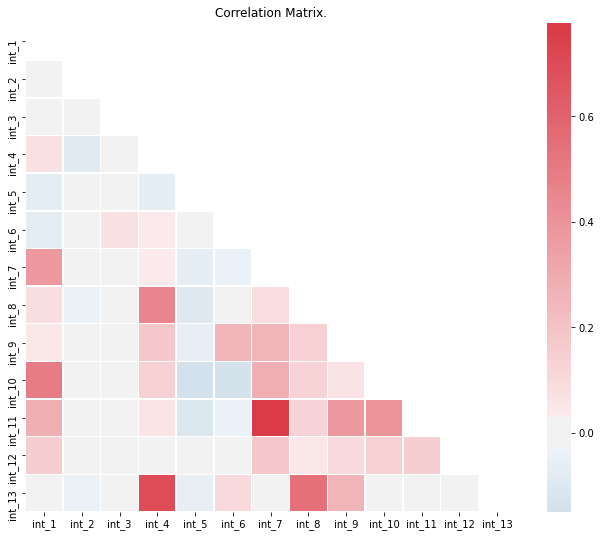

In [12]:
# Heatmap for correlations matrix
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlation Matrix.")
plt.show()

### 2.3) Histograms

Below we show several histograms of the numerical columns. We will work with a limited subset of data due to inefficiencies with Spark graph plotting.

Most of the columns have large number of 0 values. There is right skewness in the distribution likely due to this fact as well. We also observe many outliers, which in turn affect could affect our algorithm (by lowering the predictive power).

In [13]:
sample_df = fullWithColsDF.sample(False, fraction=0.1, seed = 1)
sample_df.cache()
sample_df.count()

549

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8611d827d0>,
      dtype=object)

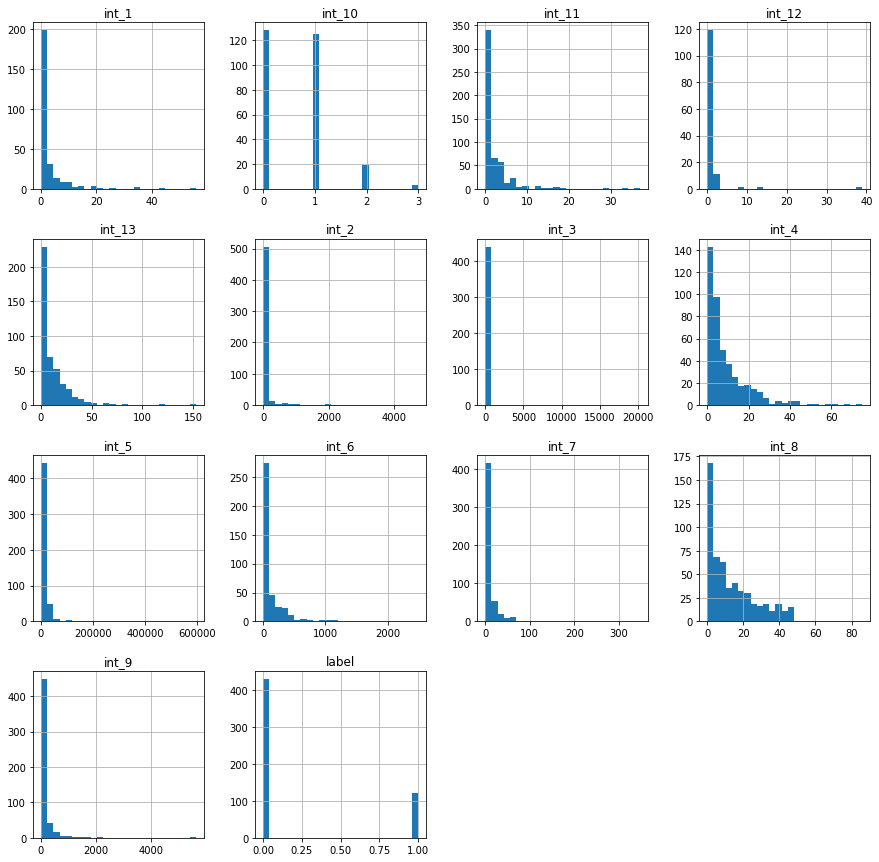

In [14]:
#Convert to Pandas DataFrame
pd_sample_df = sample_df.toPandas()
pd_sample_df.hist(figsize = (15, 15), bins = 25)

### 2.4) Graphs of Logit function

We have one more assumption of logistic regression to test - that there is a linear relationship between the logit of the outcome and each predictor variable.  Again, the logit function is $logit(p) = log(p/(1-p))$ where p is the probability of the outcome.

To save space, below we only plot the relationship between the logit of the outcome and the predictor variable "int_1".  However, this and the other numerical variables all show that this relationshp is linear.  For "int_1", this can be seen by the characteristic "S" shaped of the curve that has been generated by the sigmoid function.

Thus, our final assumption needed for logstic regression has been met, and we can move on to implementation of the algrorithm.

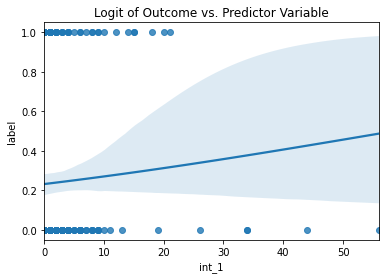

In [15]:
import warnings
warnings.filterwarnings('ignore')
log_plot_1 = sns.regplot(x = 'int_1', y = 'label', data= pd_sample_df, logistic= True).\
                set_title("Logit of Outcome vs. Predictor Variable")

## 3) Algorithm Explanation - With Toy Example

As we have shown that we have met all the assumptions for logistic regression, we will proceed to use it for our Click Through Rate prediction task.

Before we perform the prediction on the Criteo dataset, we will begin by explaining the methodology behind how to apply linear regression to a toy (small and artifical) dataset that has a binary target variable and a mix of numerical and categorical columns. 

### 3.1) The "Toy" Dataset

In order to test our data processing code and overall analysis methodology, we created a "toy" dataset consisting of 40 rows of data, with a label column, 4 integer feature columns, and 4 categorical feature columns.

Each row in the toy dataset contains information about an individual person.  The  dataset's output variable, `income_over_80k`, denotes whether an individual's income exceeds $80,000 per year.  All the variables in the toy dataset are described below:

- income_over_80k: 0 if income is less than 80,000 dollars per year, 1 if greater than 80,000 dollars per year.
- house_sqft: (Integer) The square footage of the individual's home
- letters_in_middle_name: (Integer) The number of letters in the individual's middle name.
- birth_minutes_after_midnight: (Integer) The number of minutes after midnight at which an individual was born (e.g., 9:30AM = 570 minutes after midnight).
- largest_tv_diagonal: (Integer) The diagonal length in inches of the largest television owned by the individual.
- car_continent: (Categorical) The continent on which the individual's primary car was manufactured (america, asia, or europe).
- own_or_rent: (Categorical) Denotes whether the individual owns or rents their home. (own or rent)
- ice_cream: (Categorical) Denotes an individual's preferred flavor of ice cream from the choices chocolate, strawberry, or vanilla.
- chicken_wings: (Categorical) Denotes an individual's preferred spice level of chicken wings (mild, medium, or hot). 

The dataset was constructed in a manner such that there are correlations between some of the variables and the likelihood of having an income more than $80,000.  Some variables were constructed to have no correlation, and an error component was used when building the labels for the data, to ensure no perfect models could be generated.

In [16]:
# read in the toy dataset
toy_pddf=pd.read_csv('data/toy_dataset_predicting_income_over_80k_LABEL_INT_CAT.csv')
toy_pddf.head(3)

,income_over_80k,house_sqft,letters_in_middle_name,birth_minutes_after_midnight,largest_tv_diagonal,car_continent,own_or_rent,ice_cream,chicken_wings
0,0,1540,4,400,47,america,own,vanilla,hot
1,0,2480,12,335,76,america,rent,chocolate,hot
2,0,1544,5,297,36,asia,own,chocolate,hot


In [17]:
# Write a tsv to make a file in the same format as the input real data
toy_pddf.to_csv('data/toydata.txt', sep='\t', header=False, index=False)
# Create an RDD
toyRDD = sc.textFile('data/toydata.txt')
# Verify the toyRDD is in the same TSV format as real data.
toyRDD.take(4)

['0\t1540\t4\t400\t47\tamerica\town\tvanilla\thot',
 '0\t2480\t12\t335\t76\tamerica\trent\tchocolate\thot',
 '0\t1544\t5\t297\t36\tasia\town\tchocolate\thot',
 '1\t3060\t3\t282\t35\tamerica\town\tvanilla\thot']

In [18]:
# Create an RDD
toyRDD = sc.textFile('data/toydata_missing.txt')
# Verify the toyRDD is in the same TSV format as real data.
toyRDD.take(7)

['0\t1540\t4\t400\t47\t\town\tvanilla\thot',
 '0\t2480\t12\t335\t76\tamerica\trent\tchocolate\thot',
 '0\t1544\t5\t297\t36\tasia\town\tchocolate\thot',
 '1\t3060\t3\t282\t35\tamerica\town\tvanilla\thot',
 '0\t3437\t11\t775\t64\tamerica\trent\tvanilla\tmild',
 '0\t\t6\t605\t62\tamerica\town\tchocolate\thot',
 '0\t1473\t9\t734\t28\tasia\town\tvanilla\tmedium']

In [19]:
# Helper function to split a line of data into the appropriately typed variablces

def split_data(line, n_ordinal_cols=13):
    """
    input format: "label \t <ordinal_cols> \t <categorical_cols>"
    line arrives as a string.
    Split a line of raw data into a list.
    label is first element.  The next <n_ordinal_cols> are ints,
    all others after that are categorical.
    """
    data = line.split('\t')
    result = [int(data[0])]
    # Note that leaving the ord column values as empty means we can later use an Imputer to replace them
    result.extend([ord for ord in data[1:n_ordinal_cols+1]])
    result.extend([cat if cat !='' else 'UNSPECIFIED' for cat in data[n_ordinal_cols+1:]])
    
    return result

In [20]:
# Deal with missing values in numeric columns, replacing them with the mean value for the variable in question

from pyspark.ml.feature import Imputer

def data_imputer(dataRDD, first_ind_col, num_ind_cols):
    """ Replace all empty/missing numaric values with the mean value across all records. """
    df = dataRDD.toDF()

    col_names = []
    # Iterate through  the numeric columns positions, casting each as a FloatType
    for colind in range(first_ind_col, first_ind_col+num_ind_cols):
        colname = '_'+str(colind+1)
        col_names.append(colname)
        df = df.withColumn(colname, df[colname].cast(types.FloatType()))

    # Build an imputer that will process all numeric columns as input and output, replacing them
    imputer = Imputer(
        inputCols=col_names,
        outputCols=col_names
    )
    df = imputer.fit(df).transform(df)
    return df.rdd.cache()


In [21]:
# Parse the raw toyRDD
toy_parsedRDD = toyRDD.map(lambda line: split_data(line, n_ordinal_cols=4))

print("Toy Parsed data:")
for item in toy_parsedRDD.take(9):
    print(f"{item}")

Toy Parsed data:
[0, '1540', '4', '400', '47', 'UNSPECIFIED', 'own', 'vanilla', 'hot']
[0, '2480', '12', '335', '76', 'america', 'rent', 'chocolate', 'hot']
[0, '1544', '5', '297', '36', 'asia', 'own', 'chocolate', 'hot']
[1, '3060', '3', '282', '35', 'america', 'own', 'vanilla', 'hot']
[0, '3437', '11', '775', '64', 'america', 'rent', 'vanilla', 'mild']
[0, '', '6', '605', '62', 'america', 'own', 'chocolate', 'hot']
[0, '1473', '9', '734', '28', 'asia', 'own', 'vanilla', 'medium']
[0, '2132', '6', '392', '17', 'asia', 'own', 'chocolate', 'medium']
[0, '1721', '9', '651', '58', 'asia', 'rent', 'vanilla', 'mild']


### 3.2) One-Hot Encoding

To account for the categorical columns in our dataset, we will use one-hot encoding (OHE). One-hot encoding is used to represent categorical variables as binary values. One-hot encoding is necessary as machine learning algorithms, including regression, cannot directly work with categorical data. When implementing one-hot encoding, every label that is observed for a category is used to create additional columns. Any time one of these labels is observed for a record, a “1” will be entered into the corresponding column. If a label is not observed for a record, a “0” will be entered into the corresponding column.

For example, in the toy dataset, the `ice_cream` column takes on one of three values--'chocolate','strawberry', or 'vanilla'.  To one-hot-encode the `ice_cream` column, a new columns for all but the unique flavors of ice cream are created (e.g., `ice_cream_chocolate`, `ice_cream_strawberry`, and `ice_cream_vanilla`).

One important thing to note is that we will be creating a sparse matrix representation with one-hot encoding. This will be important for scalability and memory utilization concerns. Sparse matrices and vectors are most useful when a large number of values in a dataset are 0. As shown in our EDA, the Criteo dataset contains a large proporion of values that are 0, thus making it ideal for sparse representation. Sparse representation often runs much faster than dense representation, which is important for large datasets such as the Criteo dataset.

**Citation**: We have developed our OHE functions below based on the databricks article, *Click-Through Rate Prediction Lab* (https://datascience-enthusiast.com/Python/cs120_lab3_ctr_df_celloutput.html).  In the article, one hot encoding is performed on a dataset consisting strictly of categorical features.  We have made significant modifications to the code to implement one hot encoding on mixed-type datasets, and in so doing, we have learned quite a bit about one hot coding implementation.

The `one_hot_encoding` function below takes a set of raw features and generates a sparse vector feature list with one-hot-encoded columns.  Numeric features are kept in their original form.  This function is not called directly, but is called by a generator function shown next.

In [22]:
def one_hot_encoding(raw_feats, ohe_dict_broadcast, num_ohe_feats, first_categorical_column_index, use_old_version=False):
    
    """Function to produce a one-hot-encoding from a list of features and an OHE dictionary    
    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).
        first_categorical_column_index (JIM) (int): the column index within the features list
        corresponding to the first categorical feature.
    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    # Vector created:
    # - total number of features (int + cat)
    # - [ (field number, value) ]  (one tuple per numeric col and one tuple per one hot encoded categorical col)

    if use_old_version:
        retObj = SparseVector(num_ohe_feats, [(ohe_dict_broadcast.value[ftrTpl], 1.) for ftrTpl in raw_feats])
    else:
        # Debug addition: only add item to sparsevector if the discovered ftrTpl is in ohe_dict_broadcast set of keys
        retObj = SparseVector(first_categorical_column_index+num_ohe_feats,
                          raw_feats[:first_categorical_column_index] \
                          +[(ohe_dict_broadcast.value[ftrTpl], 1.) \
                            for ftrTpl in raw_feats[first_categorical_column_index:] if ftrTpl in ohe_dict_broadcast.value]
                         )

    return retObj

The `ohe_udf_generator` function below generates a user-defined function (UDF) which operates on a row of a dataframe. The generator function takes a one-hot-encoding dictionary as its input, which will be shown later.

In [23]:
from pyspark.sql.functions import udf
#from pyspark.mllib.linalg import VectorUDT

# Added first_categorical_column_index to this generator, because we must
# define it in the one_hot_encoding function.
def ohe_udf_generator(ohe_dict_broadcast, first_categorical_column_index, use_old_version=False):
    """Generate a UDF that is setup to one-hot-encode rows with the given dictionary.
    Args:
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        first_categorical_column_index (JIM) (int): the index of the first categorical column
        in the features list.
    Returns:
        UserDefinedFunction: A UDF can be used in `DataFrame` `select` statement to call a
            function on each row in a given column.  This UDF should call the one_hot_encoding
            function with the appropriate parameters.
    """
    length = len(ohe_dict_broadcast.value.keys())
    return udf(lambda x: one_hot_encoding(raw_feats=x,
                                          ohe_dict_broadcast=ohe_dict_broadcast,
                                          num_ohe_feats=length,
                                          first_categorical_column_index=first_categorical_column_index,
                                          use_old_version=use_old_version), VectorUDT())

The `createOneHotDict` function below takes an RDD and categorical column index list as input and  returns a dictionary with the following format:
- key: tuple of feature number and a unique string value
- value: a unique integer index which holds the index value in the sparse feature vector that holds the one-hot-encoded indicator variable value for the given feature and value.  Using the OHE information for `chicken_wings`, we see the following dictionary entries: `(7, 'hot'): 12, (7, 'medium'): 13, (7, 'mild'): 14`.  Notice all three tuples have 7 as their first element.  This is because `chicken_wings` is column 7 in the features list.  the values 12, 13, and 14 indicate that in the OHE sparse feature vector, indeces 12, 13, and 14 correspond to 'hot', 'medium', and 'mild', respectively.

In [24]:
import operator
# Added categorical_col_index_list and keep_all_but_one
def createOneHotDict(inputData, categorical_col_index_list, keep_all_but_one=False):
    """Creates a one-hot-encoder dictionary based on the input data.
    Args:
        inputData (RDD of lists of (int, str)): An RDD of observations where each observation is
            made up of a list of (featureID, value) tuples.
            
        categorical_col_index_list (JIM) (list): List of column indeces in features list
        corresponding to categorical variables.
        
        keep_all_but_one (JIM) (bool): Do you want to exclude 1 one-hot-encoded column from each
        categorical variable? Default is False.
        
    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """
    retObj = (inputData
               .select(explode('features'))
               .distinct()
               .rdd
               .map(lambda r: tuple(r[0]))
               .zipWithIndex()
               .collectAsMap())
    # If I were smarter, I'd filter before creating the dictionary
    # Since I don't know dataframes, I will filter the dict here
    # to only include those feature ids that are cats
    # narrow down to just the cat cols.  Note: this makes a col for every unq value
    # POR function below
    #retObj={k: retObj[k] for k in retObj.keys() if k[0] in categorical_col_index_list}
    # Debug addition: Don't include blanks as lookup in dict
    retObj={k: retObj[k] for k in retObj.keys() if (k[0] in categorical_col_index_list and len(k[1])>0)}
    # if we want to eliminate 1 value by feature (in OHE you keep all but 1 val in a given cat col)
    if keep_all_but_one:
        # keep track of feature nums for which we've already deleted 1 item
        found_feature_nums=[]
        # get current set  of keys and put into a list (or you'll get an error!) 
        allkeys=list(retObj.keys())
        # Iterate through keys
        for curr_key in allkeys:
            #If the key's feature id has not yet had an element found and deleted, then we need to delete this key
            if curr_key[0] not in found_feature_nums:
                #eliminate this key
                del retObj[curr_key]
                # add to our list of feature ids for which we've deleted a key
                found_feature_nums.append(curr_key[0])

    # sort keys by key[0] (the col number)
    # start a counter at lowest cat col number.  Every new categorical value
    # increments the counter.
    sorted_keys=sorted(retObj.keys(), key = operator.itemgetter(0, 1))
    retObj={k:i+min(categorical_col_index_list) for i,k in enumerate(sorted_keys)}
    
    return retObj

We will use the `toy_norm` data (with standardized numeric features) as the dataset for one-hot-encoding.

### 3.3) Standardize Numeric variables

For gradient descent to converge quickly when including regularization, numeric and ordinal variables should be standardized to put them all into comparable units.  A common standardization method is to subtract the mean from every observation and divide by the standard deviation.

The real data will be standardized using the StandardScaler function from the ml_feature package.  For the toy dataset, the function below demonstrates how standardization is performed.


In [25]:
## Standardize
def standardize_numeric_cols(inputRDD, numeric_column_index_list):
    """
    Takes an rdd as input [x,x,x,x]
    and a list of numeric column indeces.  The means and stdevs of
    these cols are computed, then the values in the input RDD are standardized
    by subtracting the mean and dividing by stdev.
    output rdd is same format as input.
    """

    def zscore(line, means_list=None, stdevs_list=None):
        """
        applies the transformation
        """
        m=means_list.copy()
        s=stdevs_list.copy()

        # output record starts as blank list
        output_record=[]
        # loop through cols and add them to output_record
        for i in range(len(line)):
            # If one of the numeric indeces, apply the transformation ((x-mean)/stdev)
            if i in numeric_indeces_list_broadcast.value:
                output_record.append((line[i]-m.pop(0))/s.pop(0))
            # otherwise, just append the col value.
            else:
                output_record.append(line[i])
        # output the full record
        yield output_record

    # get means and stdevs
    numeric_column_index_list.sort()
    summary = Statistics.colStats(inputRDD.map(lambda x: [x[i] for i in numeric_column_index_list]))
    means=list(summary.mean())  # a dense vector containing the mean value for each column
    stdevs=list(np.sqrt(summary.variance()))  # column-wise variance
    
    # Broadcast the list of numeric column indeces
    numeric_indeces_list_broadcast=sc.broadcast(numeric_column_index_list)

    # Apply the transformation
    outputRDD=inputRDD.flatMap(lambda line: zscore(line, means, stdevs))

    return outputRDD 
    

In [26]:
toy_parsedRDD.take(10)

[[0, '1540', '4', '400', '47', 'UNSPECIFIED', 'own', 'vanilla', 'hot'],
 [0, '2480', '12', '335', '76', 'america', 'rent', 'chocolate', 'hot'],
 [0, '1544', '5', '297', '36', 'asia', 'own', 'chocolate', 'hot'],
 [1, '3060', '3', '282', '35', 'america', 'own', 'vanilla', 'hot'],
 [0, '3437', '11', '775', '64', 'america', 'rent', 'vanilla', 'mild'],
 [0, '', '6', '605', '62', 'america', 'own', 'chocolate', 'hot'],
 [0, '1473', '9', '734', '28', 'asia', 'own', 'vanilla', 'medium'],
 [0, '2132', '6', '392', '17', 'asia', 'own', 'chocolate', 'medium'],
 [0, '1721', '9', '651', '58', 'asia', 'rent', 'vanilla', 'mild'],
 [1, '2212', '4', '1018', '54', 'america', 'own', 'chocolate', 'medium']]

In [27]:
# use the imputer function (defined above) to impute missing values in RDD

from pyspark.ml.feature import Imputer

toy_parsedRDD = data_imputer(toy_parsedRDD, 1,4)

print("toy_parsedRDD before:")
for item in toy_parsedRDD.take(2):
    print("    ", item)
    
# standardize numeric variables
toy_norm=standardize_numeric_cols(inputRDD=toy_parsedRDD, numeric_column_index_list=[1,2,3,4])
toy_norm.take(2)
 
toy_norm_list = toy_norm.collect()

print("toy_parsedRDD after imputing:")
for item in toy_parsedRDD.take(2):
    print("     ", item)


toy_parsedRDD before:
     Row(_1=0, _2=1540.0, _3=4.0, _4=400.0, _5=47.0, _6='UNSPECIFIED', _7='own', _8='vanilla', _9='hot')
     Row(_1=0, _2=2480.0, _3=12.0, _4=335.0, _5=76.0, _6='america', _7='rent', _8='chocolate', _9='hot')
toy_parsedRDD after imputing:
      Row(_1=0, _2=1540.0, _3=4.0, _4=400.0, _5=47.0, _6='UNSPECIFIED', _7='own', _8='vanilla', _9='hot')
      Row(_1=0, _2=2480.0, _3=12.0, _4=335.0, _5=76.0, _6='america', _7='rent', _8='chocolate', _9='hot')


To get into the same format of real data, write toy dataset as headerless csv, then read it into a dataframe.

In [28]:
# Write toy_norm to a headerless csv
import csv
with open("data/toy_norm.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(toy_norm_list)
# read it into a dataframe
toy_exDF = sqlContext.read.text('data/toy_norm.csv').withColumnRenamed("value", "text")
toy_exDF.head(6)

[Row(text='0,-0.4580773726103786,-1.2049553978690812,-0.5618119260143785,0.580739068900467,UNSPECIFIED,own,vanilla,hot'),
 Row(text='0,0.3391651501469513,1.4180767607574896,-0.7126962362754449,2.0777553353994485,america,rent,chocolate,hot'),
 Row(text='0,-0.45468485123694313,-0.8770763780407599,-0.8009055253511452,0.0129053126422326,asia,own,chocolate,hot'),
 Row(text='1,0.831080749295091,-1.5328344176974027,-0.8357249815652374,-0.0387159379266978,america,own,vanilla,hot'),
 Row(text='0,1.1508258887413818,1.0901977409291683,0.30867447933792785,1.4583003285722838,america,rent,vanilla,mild'),
 Row(text='0,-2.0706307519457727e-08,-0.5491973582124385,-0.08594602442178433,1.355057827434423,america,own,chocolate,hot')]

Here we split the toy dataset into train and test.

In [29]:
weights = [0.9, 0.05, 0.05]
seed = 42
toy_train, toy_val, toy_test = toy_exDF.randomSplit(weights, seed)

print("Train count:", toy_train.cache().count())
print("Val count:", toy_val.cache().count())
print("Test count:", toy_test.cache().count())

Train count: 37
Val count: 2
Test count: 1


In [30]:
def parse_line(line, categorical_col_index_list, delimiter=','):
    """
    Converts a comma separated string into a list of (featureID, value) tuples.
    Args:
        line (str): A comma separated string representing a line of data
        categorical_col_index_list (JIM) (list): a list of indeces within the
            comma-separated string that are categorical columns.
    Returns:
        list: A list of (featureID, value) tuples"
    """
    # return numbered tuples of featureid and value
    firstcat=min(categorical_col_index_list)
    num_parsed=[(i,s) if s!='' else (i,'nan') for i,s in enumerate(line.split(delimiter)[1:firstcat])]
    cat_parsed=[(i+firstcat-1,s) if s!='' else (i+firstcat-1,'UNSPECIFIED') for i,s in enumerate(line.split(delimiter)[firstcat:])]
    
    return num_parsed + cat_parsed
    #return [(i,s) for i,s in enumerate(line.split(delimiter)[1:])]


In [31]:
############### Now run it ###############################
# Notice the catcols here are 5,6,7,8 because the label column is still in col 0
# It won't be in the output!
toy_catcols=[5,6,7,8]


first_record=toy_exDF.select('text').first()[0]
toy_parsed_line=parse_line(first_record, toy_catcols)
print("first_record: " + str(first_record))
print("Output has label col removed.  Each tuple is (feature number, feature value)")
print(toy_parsed_line)

# this function outputs a list that is compatible with a sparse vector.

first_record: 0,-0.4580773726103786,-1.2049553978690812,-0.5618119260143785,0.580739068900467,UNSPECIFIED,own,vanilla,hot
Output has label col removed.  Each tuple is (feature number, feature value)
[(0, '-0.4580773726103786'), (1, '-1.2049553978690812'), (2, '-0.5618119260143785'), (3, '0.580739068900467'), (4, 'UNSPECIFIED'), (5, 'own'), (6, 'vanilla'), (7, 'hot')]


In [32]:
toy_catcols=[5,6,7,8]

from pyspark.sql.functions import udf, split
from pyspark.sql.types import ArrayType, StructType, StructField, LongType, StringType, FloatType, DoubleType

# parse_line_jim with catcols embedded
def plj_hardcode(line):
    return parse_line(line, toy_catcols)

parse_line_udf = udf(plj_hardcode,
                     ArrayType(StructType([StructField('_1', LongType()),
                                                         StructField('_2', StringType())])))

def parse_raw_df(raw_df, delimiter=','):
    """Convert a DataFrame consisting of rows of comma 
    separated text into labels and feature.
    Args:
        raw_df (DataFrame with a 'text' column): DataFrame 
        containing the raw comma separated data.
    Returns:
        DataFrame: A DataFrame with 'label' and 'feature' columns.
    """

    allfeatures=raw_df.select(split(raw_df.text, delimiter))
    print(allfeatures)
    #return None
    # POR function is returning a tuple:
    # the 0th item of the split text string, cast it as a double and call it label
    # the parsed_line_jim output
    return (raw_df.select(
                            split(raw_df.text, delimiter).getItem(0).cast("double").alias('label'),
                         parse_line_udf(raw_df.text).alias('features'))
                        .cache())

In [33]:
# Parse the raw training DataFrame
toy_parsed_train_df = parse_raw_df(toy_train.select('text'))

from pyspark.sql.functions import (explode, col)
toy_num_categories = (toy_parsed_train_df
                    .select(explode('features').alias('features'))
                    .distinct()
                    .select(col('features').getField('_1').alias('featureNumber'))
                    .groupBy('featureNumber')
                    .sum()
                    .orderBy('featureNumber')
                    .collect())

print(toy_num_categories[2][1])
toy_parsed_train_df.show(2,False)

DataFrame[split(text, ,): array<string>]
74
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                 |
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|0.0  |[[0, -0.07472245741217316], [1, -1.2049553978690812], [2, 1.8151962848676526], [3, 2.542346590519822], [4, europe], [5, rent], [6, chocolate], [7, mild]]|
|0.0  |[[0, -0.2129677033796676], [1, 1.0901977409291683], [2, 0.6800820122882452], [3, -1.071140949305306], [4, asia], [5, rent], [6, chocolate], [7, medium]] |
+-----+-------------------------------------------------------------------------------------------------------------------------------------------

In [34]:
# catcols WITHIN THE PARSED FEATURES
toy_catcols_flist=[4,5,6,7]
toy_ohe_dict = createOneHotDict(toy_parsed_train_df, toy_catcols_flist)
toy_num_ohe_feats = len(toy_ohe_dict)
print("TOY Number of OHE Features Generated")
print(len(toy_ohe_dict))

print(toy_ohe_dict)

TOY Number of OHE Features Generated
12
{(4, 'UNSPECIFIED'): 4, (4, 'america'): 5, (4, 'asia'): 6, (4, 'europe'): 7, (5, 'own'): 8, (5, 'rent'): 9, (6, 'chocolate'): 10, (6, 'strawberry'): 11, (6, 'vanilla'): 12, (7, 'hot'): 13, (7, 'medium'): 14, (7, 'mild'): 15}


### 3.4) Applying OHE to the toy dataset

At this point, we are ready to apply the OHE to the toy dataset to create one-hot encoded features. 

Here is where we do the one hot encoding on the data.  The output dataframe will have a label column, and a features column.  The features column will be a sparse vector.

The sparse vector format is a three item tuple.  The first item is the total length of the full vector (this will be the number of numeric features plus the number of one hot encoded columns).  The second item is a list of vector indeces whose values are non-zero, and the third item is a list of the values corresponding to those indeces.

In [35]:
# broadcast the ohe dict to all workers
toy_ohe_dict_broadcast = sc.broadcast(toy_ohe_dict)
# set the column index of the first categorical variable in the features list
toy_firstcat = 4
toy_ohe_dict_udf =  ohe_udf_generator(toy_ohe_dict_broadcast, toy_firstcat)
toy_ohe_train_df = toy_parsed_train_df.select(toy_ohe_dict_udf(toy_parsed_train_df.features).alias('features'), toy_parsed_train_df.label).cache()

In [36]:
toy_ohe_train_rdd = toy_ohe_train_df.rdd.cache()
# mean and variance of the outcome variable 
meanQuality = toy_ohe_train_rdd.map(lambda x: x[1]).mean()
varQuality = toy_ohe_train_rdd.map(lambda x: x[1]).variance()
print(f"Mean: {meanQuality}")
print(f"Variance: {varQuality}")

Mean: 0.24324324324324326
Variance: 0.1840759678597517


In [37]:
firstcat = 4
BASELINE = np.append(meanQuality, np.zeros(firstcat + toy_num_ohe_feats))

In [38]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [39]:
# function to compute loss (adapted from HW 4)
def LOGLoss(dataRDD, W):
    """
    Compute error.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    ################## YOUR CODE HERE ##################
    loss = augmentedData.map(lambda x: (-x[1] * np.log(sigmoid(W.dot(x[0]))) \
                                     - (1 - x[1]) * np.log(1 - sigmoid(W.dot(x[0])))) ).mean()
    ################## (END) YOUR CODE ##################
    return loss

In [40]:
# function to perform a single GD step (taken from HW4)
def GDUpdate(dataRDD, W, learningRate = 0.1):
    """
    Perform one OLS gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    
    ################## YOUR CODE HERE ################# 
    grad = augmentedData.map(lambda x: (W.dot(x[0]) - x[1])*x[0]).mean() * 2
    new_model = W - learningRate * grad
    ################## (END) YOUR CODE ################# 
   
    return new_model

In [41]:
# OLS gradient descent function (taken from HW 4)
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        ############## YOUR CODE HERE #############
        model = GDUpdate(trainRDD, model)
        training_loss = LOGLoss(trainRDD, model) 
        test_loss = LOGLoss(testRDD, model) 
        ############## (END) YOUR CODE #############
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [42]:
len(BASELINE)

17

In [43]:
# take a look at a few Gradient Descent steps (taken from HW 4)
nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {LOGLoss(toy_ohe_train_rdd,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(toy_ohe_train_rdd, model)
    loss = LOGLoss(toy_ohe_train_rdd, model)
    print(f"Loss: {loss}")

BASELINE:  Loss = 0.762979274661294
----------
STEP: 1
Loss: 0.7420974233171529
----------
STEP: 2
Loss: 0.7270330292080853
----------
STEP: 3
Loss: 0.7159326169132674
----------
STEP: 4
Loss: 0.7075855625011656
----------
STEP: 5
Loss: 0.7011825362761294


Now that we have one-hot-encoded all the toy data, we will split the data into train and test sets.

In [44]:
# split data
_, toy_ohe_test_df = toy_ohe_train_df.randomSplit([0.75,0.25])

## 4) Algorithm Implementation

After demonstrating our methodolgy for implementing binary logistic regression on our toy dataset, we are ready to implement it on the Criteo dataset.

#### Logistic Regression

At this point, we're ready to begin implementing our binary logistic regression algorithm.  Logistic regression relies on transforming a dataset using a sigmoid function.  This transformation gives the data in logistic regression an "S" shaped curve, and forces values to be between 0 and 1.  The equation for the sigmoid is:

$$ f (x) =  \frac{\mathrm{1} }{\mathrm{1} + e^-(x) }  $$ 

#### Log-Loss

Log-loss (related to cross-entropy) measures the performance of a classification model where the prediction input is a probability value between 0 and 1.  It represents a common cost, or loss function, used with logistic regression. A primary goal of the algorithm we are implementing is to minimize the log-loss value. A perfect model would have a log loss of 0. Log loss increases as the predicted probability diverges from the actual label.  The equation for log-loss is:

For a single sample with true label $y_t$ in {0,1} and estimated probability $y_p$ that $y_t$ = 1, the log loss is

$-log(P(y_t|y_p)) = -(y_t log(y_p) + (1 - y_t) log(1 - y_p))$

Here, the least absolute deviations, or L1 loss, is 

$\sum_{i=1}^m {(y-\hat{y})}$

The least square error, or L2 loss, is 

$\sum_{i=1}^m {(y-\hat{y})^2}$

#### Gradient Descent in Logistic Regression

Gradient Descent is a process that works iteratively to find the optimal parameters for a model when fed a particular training data set. It does this by using the vector of partial derivatives of a loss function to strategically update parameters in a way that will reduce the loss.  The hypothesis function for the method of gradient descent used in logistic regression is as follows:

$$\theta_j  = \frac{1}{m} \sum_{i=1}^m Cost(h_{\theta} (\pmb{x}^{(i)}), y^{(i)})$$

Where $Cost(h_{\theta}(x),y) ={−log(h_{\theta}(x))}$ if y = 1 and

$Cost(h_{\theta}(x),y) ={−log(h_{\theta}(1 - x))}$ if y = 0

and where $h_{\theta}$ is a hypothesis of the optimal value.

### 4.1) Data Standardization and Regularization

In order to ensure that the parameters have a same scale of comparison, we normalize the data using the function below. This makes the training less sensitive to the scale of features, so we can better solve for solutions. 

$$ f (x) =  \frac{x - x_{min} }{x_{max} - x_{min} }  $$ 

As indicated in the EDA, at least 12 variables, inclusive of numerical and categorical, has large chunks of empty / NA values. We therefore regularize the data using a regularization algorithm StandardScaler() to ensure that the data has a mean of 0 and a standard deviation of 1.

### 4.2) Feature Selection

In order to address the issue of collinearity between input variables, Principal Component Analysis (PCA) will be used to select the most significant feature components, resulting in an optimized signal-to-noise ratio and reduction of redundancy between features. These components are orthonormal The PCA process can be summarized as follows:
1. Center feature values
2. Compute the feature covariance matrix
3. Compute the ranked eigenvectors of the covariance matrix  

The third step may be completed through Singular Value Decomposition, with the familiar equation $\mathbf{X = U\Sigma V_T}$, in which $\mathbf{U}$ and $\mathbf{V}$ are each orthogonal matrices, $\mathbf{V}$ contains the eigenvectors of the feature covariance matrix, and $\mathbf{\Sigma}$ is a diagonalized matrix with ordered singular values on the diagonal. With this in place, $\mathbf{X}$ multiplied by the first $\mathbf{n}$ columns of $\mathbf{V}$ produces the associated subset of $\mathbf{U\Sigma}$, which is then an orthogonal matrix with $\mathbf{n}$ features.

To put this into plain terms, an orthogonal matrix is composed of perpendicular vectors, without the noise or redundancy in $\mathbf{X}$. An effective LogisticRegression model can then be trained on input data transformed in this way and tested on test data transformed in this way.

#### Drawbacks

One issue with a modeling pipeline involving PCA is the loss of explainability of results. While the predictions from such a model may be more accurate than without PCA, it would be difficult to interpret the model in terms of the original features.

In [45]:
# Prepare a PCA model to transform the toy training DataFrame to 3 principal components
pca = PCA(k=3, inputCol='features', outputCol = 'pcaFeatures')
pca_model = pca.fit(toy_ohe_train_df)

# Use PCA model to transform the train DataFrame
pca_result = pca_model.transform(toy_ohe_train_df)

print("Selected principal components:")
print(pca_result.select('pcaFeatures').take(1),'\n\n')  


Selected principal components:
[Row(pcaFeatures=DenseVector([-1.8297, -2.1565, -0.2412]))] 




### 4.2) Feature Selection

In order to address the issue of collinearity between input variables, Principal Component Analysis (PCA) will be used to select the most significant feature components, resulting in an optimized signal-to-noise ratio and reduction of redundancy between features. These components are orthonormal The PCA process can be summarized as follows:
1. Center feature values
2. Compute the feature covariance matrix
3. Compute the ranked eigenvectors of the covariance matrix  

The third step may be completed through Singular Value Decomposition, with the familiar equation $\mathbf{X = U\Sigma V_T}$, in which $\mathbf{U}$ and $\mathbf{V}$ are each orthogonal matrices, $\mathbf{V}$ contains the eigenvectors of the feature covariance matrix, and $\mathbf{\Sigma}$ is a diagonalized matrix with ordered singular values on the diagonal. With this in place, $\mathbf{X}$ multiplied by the first $\mathbf{n}$ columns of $\mathbf{V}$ produces the associated subset of $\mathbf{U\Sigma}$, which is then an orthogonal matrix with $\mathbf{n}$ features.

To put this into plain terms, an orthogonal matrix is composed of perpendicular vectors, without the noise or redundancy in $\mathbf{X}$. An effective LogisticRegression model can then be trained on input data transformed in this way and tested on test data transformed in this way.

#### Drawbacks

One issue with a modeling pipeline involving PCA is the loss of explainability of results. While the predictions from such a model may be more accurate than without PCA, it would be difficult to interpret the model in terms of the original features.

### 4.3) Logistic Regression with Lasso (L1) regularization

Uses PCA for feature selection and the resulting set of 10 features is processed by Logistic Regression with Lasso (L1) Regularization to further reduce the feature set. With L1 regularization, the training goal will be to minimize the following augmented loss function:  $$\mathbf{\Sigma -log(P(y_t|y_p)) + \lambda \Sigma| \beta_j|}$$  
The term at the end penalizes larger coefficients and based on the size of $\lambda$ may reduce coefficients to 0, thus performing feature selection.  

Note that PCA may be used for feature selection without L1 regularization, and L1 regularization may be used without PCA. In our training with a fraction of the full dataset, the memory constraints of the Spark ML implementation of PCA meant that with a larger volume of training data we needed to rely on L1 regularization alone.

In [46]:
# Define a Pipeline for training and then testing
# Pipeline includes translating DataFrame rows into Vectors, Principal Component Analysis and Logistic Regression


# normalize features
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=False)
# use PCA to identify 30 Principal Components
pca = PCA(k=8, inputCol='features', outputCol='pcaFeatures')
# logistic regression with L1 regularization (elasticNetParam=1.0), prediction threshold=0.5
logistic_reg = LogisticRegression(regParam=0.1, elasticNetParam=1.0, featuresCol='pcaFeatures', threshold=0.5)

#pipeline = Pipeline(stages=[scaler, pca, logistic_reg])

pca_model = pca.fit(toy_ohe_train_df)
toy_pca_df = pca_model.transform(toy_ohe_train_df)

print("Fitting ML pipeline with training data...")
start = time.time()
logreg_model = logistic_reg.fit(dataset=toy_pca_df)
end_fit = time.time()
print(f"...process completed in {end_fit-start} seconds.")
print("\nApplying fitted pipeline model to TOY test data")

pca_test_model = pca.fit(toy_ohe_test_df)
toy_pca_test_df = pca_model.transform(toy_ohe_test_df)
toy_result = logreg_model.transform(toy_pca_test_df)
print(f"...process completed in {time.time()-end_fit} seconds.")

Fitting ML pipeline with training data...
...process completed in 0.600208044052124 seconds.

Applying fitted pipeline model to TOY test data
...process completed in 0.1629037857055664 seconds.


### 4.4) Model Evaluation - Log Loss

For the evaluation of the model, we can use the log loss of the model and compare the result with the baseline log loss.

In [47]:
epsilon = 1e-16
def add_log_loss(df):
    """Computes and adds a 'log_loss' column to a DataFrame using 'p' and 'label' columns.

    Note:
        log(0) is undefined, so when p is 0 we add a small value (epsilon) to it and when
        p is 1 we subtract a small value (epsilon) from it.

    Args:
        df (DataFrame with 'p' and 'label' columns): A DataFrame with a probability column
            'p' and a 'label' column that corresponds to y in the log loss formula.

    Returns:
        DataFrame: A new DataFrame with an additional column called 'log_loss' where 'log_loss' column contains the loss value as explained above.
    """
    newDF = df.select("*", when(df.label == 1, 0. - log(df.p + epsilon)).\
                           otherwise(0. - log(1. - df.p + epsilon)).alias('log_loss'))
  
    retObj = newDF  
      
    return retObj

firstelement = udf(lambda v:float(v[1]),FloatType())

resultLogLossDF = toy_result.select(['label',firstelement('probability')])
resultLogLossDF = resultLogLossDF.select(col("label").alias("label"), col("<lambda>(probability)").alias("p"))
add_log_loss(resultLogLossDF).show()

log_loss_result = (add_log_loss(resultLogLossDF)
                          .groupBy()
                          .mean('log_loss')
                          .collect())[0][0]
print ('Logloss = ',log_loss_result)

+-----+-----------+-------------------+
|label|          p|           log_loss|
+-----+-----------+-------------------+
|  0.0| 0.23928064| 0.2734907684778635|
|  0.0| 0.28142476|0.33048486192181586|
|  1.0| 0.20299344| 1.5945816273209052|
|  0.0|0.109593496|0.11607717415820276|
|  0.0|  0.3189461|0.38411381784629506|
|  0.0| 0.31494343|   0.37825386428699|
|  0.0| 0.16166392| 0.1763362084067907|
|  1.0| 0.33097708|  1.105706143909976|
|  0.0| 0.27555725|0.32235254005993624|
+-----+-----------+-------------------+

Logloss =  0.5201552229320862


### 4.5) Model Evaluation - ROC Curve

We will now visualize how well the model predicts our target. To do this we generate a plot of the ROC curve. The ROC curve shows us the trade-off between the false positive rate and true positive rate, as we liberalize the threshold required to predict a positive outcome. A random model is represented by the dashed line.

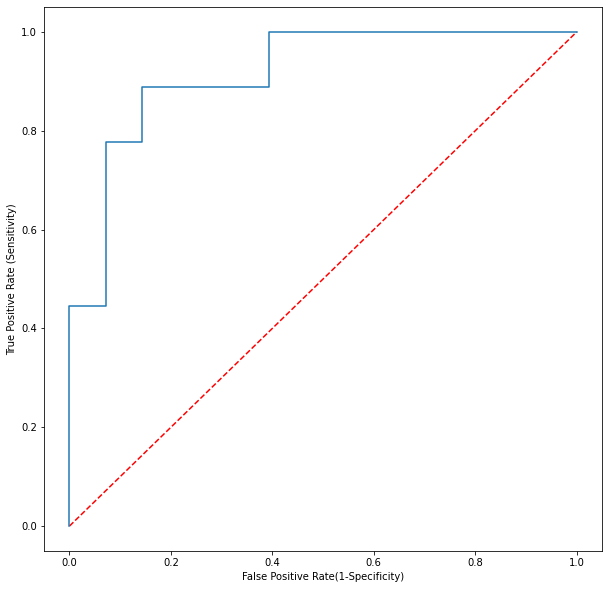

Area Under ROC :  0.9166666666666666


In [48]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(logreg_model.summary.roc.select('FPR').collect(),
         logreg_model.summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate(1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

print("Area Under ROC : ", logreg_model.summary.areaUnderROC)

# Working with the Real Dataset

In [49]:
# delete the datafile with imputed values, before regenerating it
!rm -rf data/train_imputed.txt

In [50]:
# Read in the real data for train and test
# Create an RDD
trainRDD = sc.textFile('data/train.txt')

In [51]:
# Parse the raw trainRDD and testRDD
train_parsedRDD = trainRDD.map(lambda line: split_data(line, n_ordinal_cols=13))

# impute missing values
train_parsedRDD = data_imputer(train_parsedRDD, 1,13)
    
# save the imputed training data, for later use
def toCSVLine(data):
  return '\t'.join(str(d) for d in data)
lines = train_parsedRDD.map(toCSVLine)
lines.saveAsTextFile('data/train_imputed.txt')

In [52]:
############### Now run it ###############################
catcols=[cat for cat in range(14,40)]

# Note that this is now reading in data that was previously preprocessed, with imputed missing values
rawDF = sqlContext.read.text('data/train_imputed.txt').withColumnRenamed("value", "text")
rawDF.cache()
first_record=rawDF.select('text').first()[0]
parsed_line=parse_line(first_record, catcols, delimiter='\t')

# this function outputs a list that is compatible with a sparse vector.

from pyspark.sql.functions import udf, split
from pyspark.sql.types import ArrayType, StructType, StructField, LongType, StringType, FloatType, DoubleType

# parse_line_walt with catcols embedded
def plw_hardcode(line):
    return parse_line(line, catcols, delimiter='\t')

parse_line_udf = udf(plw_hardcode,
                     ArrayType(StructType([StructField('_1', LongType()),
                                                         StructField('_2', StringType())])))

# Parse the raw training DataFrame
parsed_train_df = parse_raw_df(rawDF.select('text'), delimiter='\t')

from pyspark.sql.functions import (explode, col)
num_categories = (parsed_train_df
                    .select(explode('features').alias('features'))
                    .distinct()
                    .select(col('features').getField('_1').alias('featureNumber'))
                    .groupBy('featureNumber')
                    .sum()
                    .orderBy('featureNumber')
                    .collect())


DataFrame[split(text, 	): array<string>]


In [53]:
# catcols WITHIN THE PARSED FEATURES
catcols=[cat for cat in range(13,39)]
print(len(catcols))
ohe_dict = createOneHotDict(parsed_train_df, catcols)
num_ohe_feats = len(ohe_dict)
print("Number of OHE Features Generated")
print(num_ohe_feats)
#num_ohe_feats += len(catcols)

26
Number of OHE Features Generated
26597


In [54]:
# broadcast the ohe dict to all workers

ohe_dict_broadcast = sc.broadcast(ohe_dict)
# set the column index of the first categorical variable in the features list
firstcat = 13
ohe_dict_udf =  ohe_udf_generator(ohe_dict_broadcast, firstcat, use_old_version=False)
ohe_train_df = parsed_train_df.select(ohe_dict_udf(parsed_train_df.features) \
                                                 .alias('features'), parsed_train_df.label).cache()


In [55]:
# Split the full dataframe into train and test
ohe_split_train_df, ohe_split_test_df = ohe_train_df.randomSplit([.75,.25])

In [56]:
# Define a Pipeline for training and then testing
# Pipeline includes translating DataFrame rows into Vectors, Principal Component Analysis and Logistic Regression

# normalize features
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=True)

# logistic regression with L1 regularization (elasticNetParam=1.0), prediction threshold=0.5
logistic_reg = LogisticRegression(regParam=0.05, elasticNetParam=1.0, featuresCol='scaledFeatures', threshold=0.6)

print("Fitting ML pipeline with training data...")
start = time.time()
scaler_model = scaler.fit(ohe_split_train_df)
scaled_df = scaler_model.transform(ohe_split_train_df)
logreg_model = logistic_reg.fit(dataset=scaled_df)
end_fit = time.time()
print(f"...process completed in {end_fit-start} seconds.")

print("\nApplying fitted pipeline model to test data")
scaler_test_model = scaler.fit(ohe_split_test_df)
scaled_test_df = scaler_test_model.transform(ohe_split_test_df)
prediction = logreg_model.transform(scaled_test_df)
print(f"...process completed in {time.time()-end_fit} seconds.")
print(f"% correct: {prediction.filter('prediction == label').count()/ohe_split_test_df.count()}")

Fitting ML pipeline with training data...
...process completed in 34.59591603279114 seconds.

Applying fitted pipeline model to test data
...process completed in 0.11982893943786621 seconds.
% correct: 0.8034257748776509


In [57]:
prediction.describe().show()

+-------+------------------+----------+
|summary|             label|prediction|
+-------+------------------+----------+
|  count|              1226|      1226|
|   mean|0.1965742251223491|       0.0|
| stddev|0.3975697723342266|       0.0|
|    min|               0.0|       0.0|
|    max|               1.0|       0.0|
+-------+------------------+----------+



### 4.4) Model Evaluation - Log Loss

For the evaluation of the model, we can use the log loss of the model and compare the result with the baseline log loss.

In [58]:
epsilon = 1e-16
def add_log_loss(df):
    """Computes and adds a 'log_loss' column to a DataFrame using 'p' and 'label' columns.

    Note:
        log(0) is undefined, so when p is 0 we add a small value (epsilon) to it and when
        p is 1 we subtract a small value (epsilon) from it.

    Args:
        df (DataFrame with 'p' and 'label' columns): A DataFrame with a probability column
            'p' and a 'label' column that corresponds to y in the log loss formula.

    Returns:
        DataFrame: A new DataFrame with an additional column called 'log_loss' where 'log_loss' column contains the loss value as explained above.
    """
    newDF = df.select("*", when(df.label == 1, 0. - log(df.p + epsilon)).\
                           otherwise(0. - log(1. - df.p + epsilon)).alias('log_loss'))
  
    retObj = newDF  
      
    return retObj

firstelement = udf(lambda v:float(v[1]),FloatType())

resultLogLossDF = prediction.select(['label',firstelement('probability')])
resultLogLossDF = resultLogLossDF.select(col("label").alias("label"), col("<lambda>(probability)").alias("p"))
add_log_loss(resultLogLossDF).show()

log_loss_result = (add_log_loss(resultLogLossDF)
                          .groupBy()
                          .mean('log_loss')
                          .collect())[0][0]
print ('Logloss = ',log_loss_result)

+-----+----------+-------------------+
|label|         p|           log_loss|
+-----+----------+-------------------+
|  1.0|0.22252959| 1.5026951968704902|
|  0.0|0.22252959|0.25170969369779955|
|  0.0|0.23857889| 0.2725687046508099|
|  0.0|0.22163239|0.25055636153317057|
|  0.0|0.23857889| 0.2725687046508099|
|  0.0|0.22342938|0.25286769635262474|
|  0.0|0.24142063| 0.2763078405008003|
|  0.0|0.23952357|0.27381016672433517|
|  1.0|0.24142063| 1.4212145280687507|
|  0.0|0.22342938|0.25286769635262474|
|  0.0|0.24091592| 0.2756427360620566|
|  0.0|0.23164384| 0.2635019042060159|
|  0.0|0.24047083|0.27505654639476634|
|  1.0|0.24047083| 1.4251564998052528|
|  0.0|0.23952357|0.27381016672433517|
|  0.0|0.22385223|0.25341235437361426|
|  0.0|0.22252959|0.25170969369779955|
|  0.0|0.23952357|0.27381016672433517|
|  1.0|0.24047083| 1.4251564998052528|
|  1.0|0.22163239| 1.5067351650508232|
+-----+----------+-------------------+
only showing top 20 rows

Logloss =  0.4962618955173499


### 4.5) Model Evaluation - ROC Curve

We will now visualize how well the model predicts our target. To do this we generate a plot of the ROC curve. The ROC curve shows us the trade-off between the false positive rate and true positive rate, as we liberalize the threshold required to predict a positive outcome. A random model is represented by the dashed line.

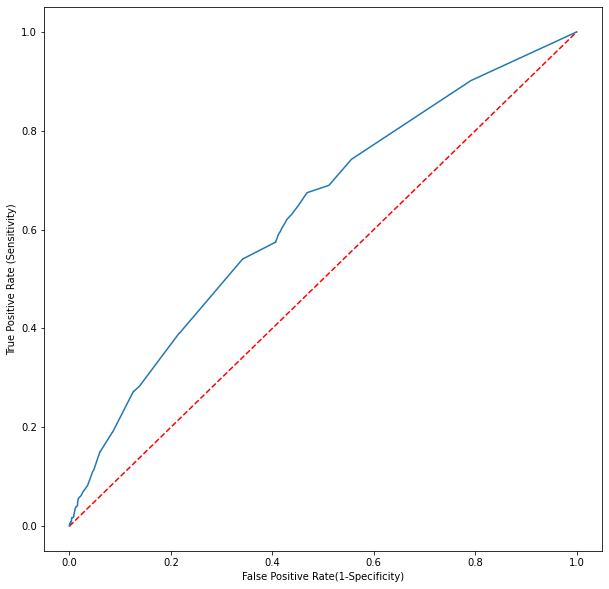

Area Under ROC :  0.6343718423911177


In [59]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(logreg_model.summary.roc.select('FPR').collect(),
         logreg_model.summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate(1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

print("Area Under ROC : ", logreg_model.summary.areaUnderROC)

## 5) Conclusion with Class Concepts & Future Improvements


### 5.1) Model Sparsity / Bias Variance Tradeoff / Model Complexity

A standardized and regularized logistic regression is a great fit for the Click Through Rate prediction, as clicks and non-clicks are observed everyday. Even though the vector is enormous, an instance will have only a small percentage of nonzero values, so the representation is extremely sparse. Each training example will only need to be examined once with potential streaming features. 

Even though Gradient Descent is considered efficient for the logistic regression models with its limited computing resources needed, the data size is nontheless throwing out a challenge in terms of our RAM/Cloud resource limit. 

Understanding the the bias–variance tradeoff (the tradeoff between a lower bias in parameter estimation and lower variance of the parameter estimates across samples) is therefore the core in the successful implementation of our algorithm. The conflict of trying to simultaneously accurately capture the training data but also generalize the test data is the key consideration we have in choosing One Hot Encoding method. 

### 5.2) Normalization and Regularization

In the original dataset, non-zero features with varying magnitudes of variances take up a significant portion and could potentially slow down the convergence. We therefore applied regularization using the StandardScaler, as explained in section 4.1. A great benefit of applying regularization to the logistic regression is that the hierarchical relationship between features are automatically considered, so the parent feature will provide the most support in the regularization process.


### 5.3) One Hot Encoding / Feature Selection
Using a one-hot-encoding featurization can yield a model with good statistical summary. However, the number of distinct categories across all features is quite large. Hence, featurizing via a one-hot encoding representation would lead to a very large feature vector. To reduce the dimensionality of the feature, we can use feature hashing. 



In [60]:
parsed_train_df.first()

Row(label=0.0, features=[Row(_1=0, _2='0.0'), Row(_1=1, _2='628.0'), Row(_1=2, _2='4.0'), Row(_1=3, _2='1.0'), Row(_1=4, _2='1732.0'), Row(_1=5, _2='291.0'), Row(_1=6, _2='57.0'), Row(_1=7, _2='19.0'), Row(_1=8, _2='19.0'), Row(_1=9, _2='0.0'), Row(_1=10, _2='7.0'), Row(_1=11, _2='0.9297945499420166'), Row(_1=12, _2='1.0'), Row(_1=13, _2='68fd1e64'), Row(_1=14, _2='287130e0'), Row(_1=15, _2='61f559fa'), Row(_1=16, _2='3c6543d9'), Row(_1=17, _2='25c83c98'), Row(_1=18, _2='UNSPECIFIED'), Row(_1=19, _2='397def4e'), Row(_1=20, _2='0b153874'), Row(_1=21, _2='a73ee510'), Row(_1=22, _2='0af798a0'), Row(_1=23, _2='20b05825'), Row(_1=24, _2='9efd7e1b'), Row(_1=25, _2='c28589ee'), Row(_1=26, _2='b28479f6'), Row(_1=27, _2='9efd8b77'), Row(_1=28, _2='c4089ccc'), Row(_1=29, _2='e5ba7672'), Row(_1=30, _2='891589e7'), Row(_1=31, _2='315ba0e1'), Row(_1=32, _2='b1252a9d'), Row(_1=33, _2='63b0486e'), Row(_1=34, _2='UNSPECIFIED'), Row(_1=35, _2='32c7478e'), Row(_1=36, _2='5e07a644'), Row(_1=37, _2='e8b83

In [61]:
rawDF.first()

Row(text='0\t0.0\t628.0\t4.0\t1.0\t1732.0\t291.0\t57.0\t19.0\t19.0\t0.0\t7.0\t0.9297945499420166\t1.0\t68fd1e64\t287130e0\t61f559fa\t3c6543d9\t25c83c98\tUNSPECIFIED\t397def4e\t0b153874\ta73ee510\t0af798a0\t20b05825\t9efd7e1b\tc28589ee\tb28479f6\t9efd8b77\tc4089ccc\te5ba7672\t891589e7\t315ba0e1\tb1252a9d\t63b0486e\tUNSPECIFIED\t32c7478e\t5e07a644\te8b83407\tdee3cffc')

In [62]:
parsed_train_df.first()

Row(label=0.0, features=[Row(_1=0, _2='0.0'), Row(_1=1, _2='628.0'), Row(_1=2, _2='4.0'), Row(_1=3, _2='1.0'), Row(_1=4, _2='1732.0'), Row(_1=5, _2='291.0'), Row(_1=6, _2='57.0'), Row(_1=7, _2='19.0'), Row(_1=8, _2='19.0'), Row(_1=9, _2='0.0'), Row(_1=10, _2='7.0'), Row(_1=11, _2='0.9297945499420166'), Row(_1=12, _2='1.0'), Row(_1=13, _2='68fd1e64'), Row(_1=14, _2='287130e0'), Row(_1=15, _2='61f559fa'), Row(_1=16, _2='3c6543d9'), Row(_1=17, _2='25c83c98'), Row(_1=18, _2='UNSPECIFIED'), Row(_1=19, _2='397def4e'), Row(_1=20, _2='0b153874'), Row(_1=21, _2='a73ee510'), Row(_1=22, _2='0af798a0'), Row(_1=23, _2='20b05825'), Row(_1=24, _2='9efd7e1b'), Row(_1=25, _2='c28589ee'), Row(_1=26, _2='b28479f6'), Row(_1=27, _2='9efd8b77'), Row(_1=28, _2='c4089ccc'), Row(_1=29, _2='e5ba7672'), Row(_1=30, _2='891589e7'), Row(_1=31, _2='315ba0e1'), Row(_1=32, _2='b1252a9d'), Row(_1=33, _2='63b0486e'), Row(_1=34, _2='UNSPECIFIED'), Row(_1=35, _2='32c7478e'), Row(_1=36, _2='5e07a644'), Row(_1=37, _2='e8b83

In [63]:
rawDF.first()

Row(text='0\t0.0\t628.0\t4.0\t1.0\t1732.0\t291.0\t57.0\t19.0\t19.0\t0.0\t7.0\t0.9297945499420166\t1.0\t68fd1e64\t287130e0\t61f559fa\t3c6543d9\t25c83c98\tUNSPECIFIED\t397def4e\t0b153874\ta73ee510\t0af798a0\t20b05825\t9efd7e1b\tc28589ee\tb28479f6\t9efd8b77\tc4089ccc\te5ba7672\t891589e7\t315ba0e1\tb1252a9d\t63b0486e\tUNSPECIFIED\t32c7478e\t5e07a644\te8b83407\tdee3cffc')

In an effort to meet the logistic regression model requirement, Lasso regularization helped us in reducing the number of parameters by discarding the least important values in the training. 

The Principal Component Analysis (PCA) binary classification method was used to select the most significant feature components to avoid multicolinearity and to achieve an optimized signal-to-noise ratio and reduction of redundancy between features. The binary classification was done to evaluate the impact of adding additional features. 

### 5.4) Higher Order Functions / Map Reduce Paradigm 

MapReduce was essential in our processing of the data by providing a parallel, distributed algorithm on a cluster. 
In this paradim, the output value of a function depends only on the arguments that are input to the function. Key ideas in this paradigm include avoiding state changes/mutable data, and using higher-order functions which take other functions as inputs. 

### 5.5) Shuffle / Combiners / Local Aggregation

The shuffle stage is when our CTR data is transferring in the cluster. In includes all the work done by the framework after the mapper emits the data and before the reducers start. The shuffle is costly as Hadoop has to examine which keys are present on each data node, compare, sort and allocate the nodes, then the data has to be transfered. The complexity is a function of the number of records output by the mappers.

A combiner is an aggregation that takes the mapper output with the same key and combine into a single record. Even though this is preferred to save shuffling time, Hadoop does not garantee the combinners will perform and the timing of it. 

Local aggregation is reducing the number of records that need to be transfered over the network in the shuffle state. In our example, in addition to the combiners, we used python dicitonaries to perform the local aggregation for model efficiency.

### 5.6) Spark vs. Hadoop
We chose Spark RDD for its faster data processing. The in-memory processing feature makes Spark faster than Hadoop MapReduce for up to 100 times for data in RAM and up to 10 times for data in storage.Spark’s RDD also enable multiple map operations in memory, while Hadoop MapReduce has to write interim results to a disk.

### 5.7) Future Improvements

Some useful future improvements includes applying the appropriate power transformation to the logistic regression, due to the exponantial distribution nature of the CTR data, as the data are heavily skewed and long tailed. Here, we apply f(x)=log(x2)  for x > 2 to the values.


In [64]:
pd_sample_df

,label,int_1,int_2,int_3,int_4,int_5,int_6,int_7,int_8,int_9,...,categ_17,categ_18,categ_19,categ_20,categ_21,categ_22,categ_23,categ_24,categ_25,categ_26
0,1.0,NaN,103.0,NaN,NaN,10284.0,22.0,18.0,4.0,82.0,...,e5ba7672,638efece,,,43c5b9eb,,32c7478e,7084dcf7,,
1,0.0,0.0,1.0,3.0,NaN,1527.0,34.0,8.0,15.0,185.0,...,e5ba7672,5cd35b65,21ddcdc9,b1252a9d,ea56537b,,32c7478e,72669222,ea9a246c,6f3c2551
2,0.0,4.0,4.0,40.0,39.0,11.0,34.0,5.0,48.0,48.0,...,e5ba7672,395856b0,21ddcdc9,a458ea53,605305ee,,32c7478e,f090fae7,001f3601,cdc744c1
3,0.0,0.0,2798.0,5.0,2.0,1588.0,45.0,5.0,40.0,197.0,...,e5ba7672,f5f4ae5b,,,6387fda4,,423fab69,d36c7dbf,,
4,0.0,NaN,44.0,1.0,1.0,18721.0,91.0,2.0,16.0,95.0,...,3486227d,2efa89c6,,,73d06dde,,93bad2c0,aee52b6f,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,0.0,0.0,-1.0,1.0,NaN,1779.0,194.0,3.0,37.0,48.0,...,07c540c4,f7be65bb,21ddcdc9,b1252a9d,,,32c7478e,,001f3601,3aea8740
545,0.0,0.0,34.0,1.0,4.0,1981.0,33.0,3.0,27.0,38.0,...,07c540c4,1304f63b,21ddcdc9,b1252a9d,9988d803,,32c7478e,abe3a684,010f6491,3f1cec84
546,0.0,0.0,113.0,NaN,4.0,1800.0,16.0,32.0,9.0,22.0,...,e5ba7672,908eaeb8,,,,,32c7478e,,,
547,0.0,NaN,60.0,20.0,1.0,6514.0,10.0,2.0,5.0,6.0,...,07c540c4,a78bd508,21ddcdc9,5840adea,c2a93b37,,32c7478e,1793a828,e8b83407,2fede552


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8614f40390>,
      dtype=object)

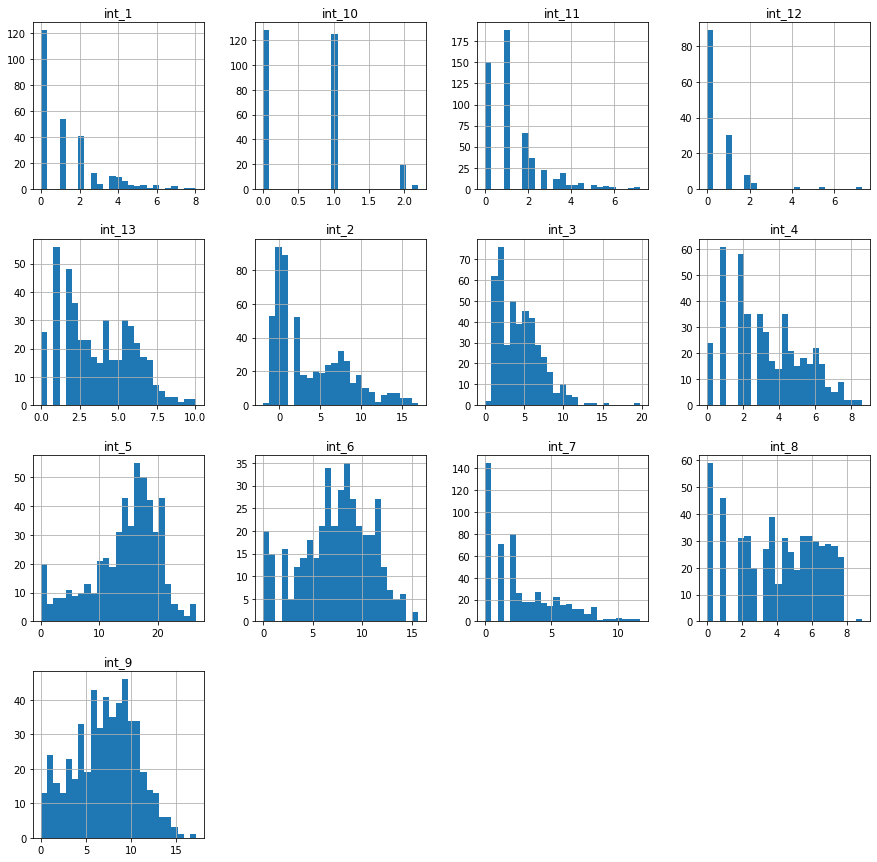

In [65]:
## apply power transformation
pd_sample_df_log = pd_sample_df.loc[:, intColList].copy()
pd_sample_df_log = pd_sample_df_log.applymap(lambda x: 2 * np.log(x) if x > 2 else x)
## Display 
pd_sample_df_log.hist(figsize = (15, 15), bins = 25)

For the cagetorical variables, infrequent values could be masked by converting values with counts less than an assigned threshold to a special value. The code is tentatively written below.

In [66]:
def convert_categorical(data, freq):
    """Converts categorical features with less frequencies into a special value.
    data : the df to process
    freq : if float and smaller than 1, convert the values that appear less than the portion. 
        If int, convert the values that appear less times.
    """
    
    frac = False if freq >= 1 else True
    special_value = 'aa'
    
    for i in range(14, 40):
        col_name = f'int_{i}'
        value_cnt = data.groupby(col_name).count()
        
        if frac:
            total_cnt = value_cnt.selectExpr("sum(count)").collect()[0][0]
            thres = total_cnt * freq
        else:
            thres = freq
        
        sc.broadcast([thres, special_value])
   


        ### convert values with count less than the threshold to the special value
        new_names = value_cnt.rdd.map(lambda x: (x[1], x[1] if x[1] > thres else special_value))
        new_names = new_names.toDF(schema=[col_name, 'new_name'])

        data = data.join(new_names, on = col_name, how = "left_outer")
        data = data.drop(col_name).withColumnRenamed('new_name', col_name).cache()
    
    return data

The data size prompted us to probe into subsampling the training data with minimal impact on accuracy, as the traning data is computaitonally unachievable to examine every instance. A potential future implementation would be to apply a model method for subsampling given the known CTR rate, as long as the conditional distribution are not affected by the subsampling. 

## 6) References

These are the list of references we relied upon to complete this final project.

Click-Through Rate Prediction Lab, https://datascience-enthusiast.com/Python/cs120_lab3_ctr_df_celloutput.html

Chapelle, O., Manavoglu, E., & Rosales, R. (2014). Simple and Scalable Response Prediction for Display Advertising. ACM Transactions on Intelligent Systems and Technology, 5(4), 1-34. doi:10.1145/2532128

Juan, Y., Zhang, Y., Shi, W. (n.d.). 3 Idiots’ Approach forDisplay Advertising Challenge. Lecture presented at NTU CSIE MLGroup.
https://www.csie.ntu.edu.tw/~r01922136/kaggle-2014-criteo.pdf


